Training: Entrenamiento del Modelo
Análisis de Sentimientos - Amazon Reviews ES
Objetivo: Entrenar modelo binario Positivo/Negativo con TF-IDF + Logistic Regression

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("INICIANDO ENTRENAMIENTO MODELO SENTIMENT")
print("=" * 60)

INICIANDO ENTRENAMIENTO MODELO SENTIMENT


1. Carga de Datos
Cargar dataset procesado por 02_preprocessing.ipynb

In [6]:
# CARGAR DATASET LIMPIO
df = pd.read_csv(r"C:\Users\coell\OneDrive\Documentos\sentimentapi-hackathon\ds\data\processed\amazon_reviews_es_5000_clean.csv")

print(f"Dataset cargado: {df.shape}")
print("Columnas:", df.columns.tolist())
print("\nDISTRIBUCIÓN CLASES:")
print(df['label_bin'].value_counts())
print(f"\nBalance - Positivo: {df['label_bin'].value_counts()['Positivo']/len(df):.1%}")

Dataset cargado: (5000, 2)
Columnas: ['text_clean', 'label_bin']

DISTRIBUCIÓN CLASES:
label_bin
Positivo    3011
Negativo    1989
Name: count, dtype: int64

Balance - Positivo: 60.2%


2. Preparación Train/Test
Split estratificado 80/20 manteniendo proporción de clases

In [22]:
# PREPARAR FEATURES Y TARGET
X = df['text_clean'] if 'text_clean' in df.columns else df['text']
y = df['label_bin'].map({'Negativo': 0, 'Positivo': 1})

print(f" Textos: {X.shape}")
print(f" Labels: {y.value_counts().to_dict()}")

# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain: {X_train.shape[0]} muestras")
print(f"Test:  {X_test.shape[0]}  muestras")

 Textos: (5000,)
 Labels: {1: 3011, 0: 1989}

Train: 4000 muestras
Test:  1000  muestras


3. Pipeline Machine Learning
TF-IDF (5000 features) + Logistic Regression optimizada

In [21]:
# CREAR PIPELINE PRODUCTION
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words=None,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ('clf', LogisticRegression(
        random_state=42,
        max_iter=2000,
        C=1.0,
        solver='liblinear'
    ))
])

print(" PIPELINE CREADO:")
for i, (name, step) in enumerate(pipeline.steps, 1):
    print(f"  {i}. {name}")


 PIPELINE CREADO:
  1. tfidf
  2. clf


4. Entrenamiento
Entrenar modelo con 4000 muestras de training

In [20]:
print(" ENTRENANDO MODELO...")
pipeline.fit(X_train, y_train)
print(" ¡ENTRENAMIENTO COMPLETADO!")


 ENTRENANDO MODELO...
 ¡ENTRENAMIENTO COMPLETADO!


5. Evaluación Accuracy
Validación cruzada interna + métricas train/test


 RESULTADOS DE ACCURACY
Train Accuracy: 0.881
Test Accuracy:  0.785
🔺 Gap (Overfitting): 0.096


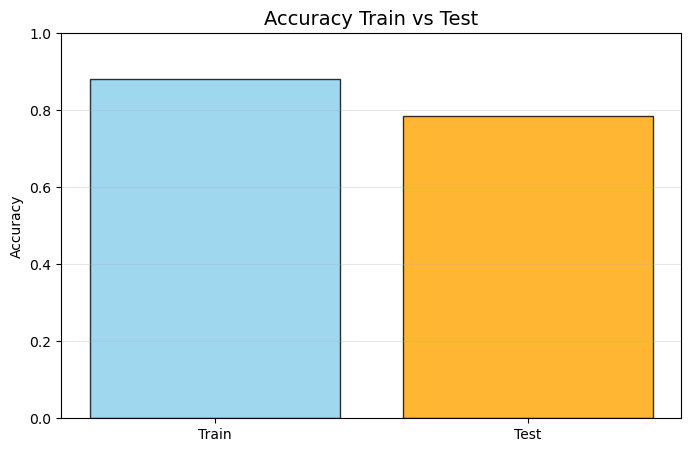

In [19]:
# CALCULAR ACCURACY
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print(f"\n RESULTADOS DE ACCURACY")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy:  {test_acc:.3f}")
print(f"🔺 Gap (Overfitting): {train_acc - test_acc:.3f}")

plt.figure(figsize=(8, 5))
plt.bar(['Train', 'Test'], [train_acc, test_acc], 
        color=['skyblue', 'orange'], alpha=0.8, edgecolor='black')
plt.title('Accuracy Train vs Test', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../models/accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


6. Métricas Detalladas
Precision, Recall, F1-Score por clase

In [12]:
# PREDICCIONES Y REPORT
y_pred = pipeline.predict(X_test)
print("\n📈 CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred, 
                          target_names=['Negativo', 'Positivo'],
                          digits=3))



📈 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negativo      0.782     0.638     0.703       398
    Positivo      0.787     0.882     0.832       602

    accuracy                          0.785      1000
   macro avg      0.784     0.760     0.767      1000
weighted avg      0.785     0.785     0.780      1000



7. Matriz de Confusión
Visualización errores de clasificación

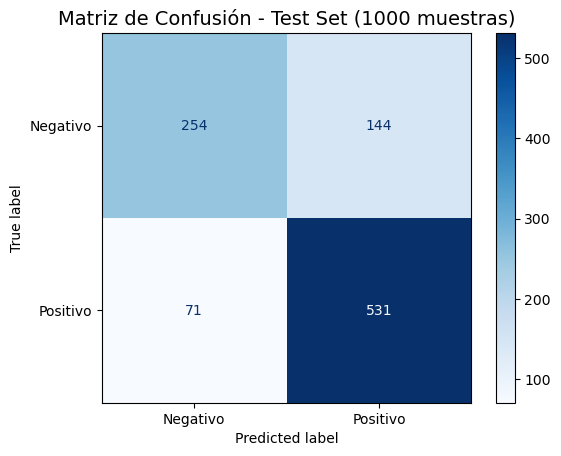


 Errores totales: 215 de 1000 (21.5%)


In [18]:
# MATRIZ CONFUSIÓN
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negativo', 'Positivo'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Test Set (1000 muestras)', fontsize=14)
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Errores totales: {cm.sum() - cm.trace()} de {cm.sum()} ({100*(cm.sum() - cm.trace())/cm.sum():.1f}%)")

8. Ejemplo Predicciones
Probar modelo con reviews reales

In [16]:
# PREDICCIONES MANUALES
ejemplos = [
    "Excelente producto, muy buena calidad",
    "Pésimo servicio, nunca más compro",
    "Regular, cumple lo básico"
]

for texto in ejemplos:
    pred = pipeline.predict([texto])[0]
    prob = pipeline.predict_proba([texto])[0]
    print(f" '{texto}'")
    print(f" Pred: {'Positivo' if pred else 'Negativo'} "
          f"(Confianza: {max(prob):.1%})")
    print()


 'Excelente producto, muy buena calidad'
 Pred: Positivo (Confianza: 94.7%)

 'Pésimo servicio, nunca más compro'
 Pred: Negativo (Confianza: 63.3%)

 'Regular, cumple lo básico'
 Pred: Positivo (Confianza: 75.2%)



9. Exportar Production
Modelo listo para API FastAPI

In [17]:
# GUARDAR ARCHIVOS PRODUCTION
joblib.dump(pipeline, "../models/sentiment_modelo_v1.pkl")
joblib.dump(pipeline.named_steps['tfidf'], "../models/tfidf_vectorizer.pkl")

print(" ARCHIVOS EXPORTADOS:")
print("  models/sentiment_modelo_v1.pkl  ← Pipeline completo")
print("  models/tfidf_vectorizer.pkl     ← Solo vectorizador")
print("  models/confusion_matrix.png     ← Visualización")
print("  models/accuracy_comparison.png  ← Comparación")

print("\n ¡MODELO PRODUCTIVO LISTO!")



 ARCHIVOS EXPORTADOS:
  models/sentiment_modelo_v1.pkl  ← Pipeline completo
  models/tfidf_vectorizer.pkl     ← Solo vectorizador
  models/confusion_matrix.png     ← Visualización
  models/accuracy_comparison.png  ← Comparación

 ¡MODELO PRODUCTIVO LISTO!
